In [1]:
pip install tld

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow scikeras scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


# GoPhish feature extraction

### Importing libraries

In [3]:
import re
import string
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from gensim.models import Word2Vec
#import tldextract
#import hashlib
#import warnings

### Importing csv file

Edited csv file to only show a value for 1 if the url is malicious, defaced or has malware. The URL will be marked as 0 if it is benign

In [4]:
url_data = pd.read_csv('goPhish_url_data.csv') #reading data
url_data.head()

url  type
0                                   br-icloud.com.br     1
1                mp3raid.com/music/krizz_kaliko.html     0
2                    bopsecrets.org/rexroth/cr/1.htm     0
3  http://www.garage-pirenne.be/index.php?option=...     1
4  http://adventure-nicaragua.net/index.php?optio...     1

In [5]:
url_data.info() #Displaying some information about the csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.9+ MB


### Checking for null values in dataset

In [6]:
url_data.isnull().sum() #isnull() returns boolean value, .sum() returns the sum of the values

url     0
type    0
dtype: int64

### Extracting count of each value

In [7]:
count = url_data['type'].value_counts()
print(count)

0    428103
1    223088
Name: type, dtype: int64


### Normalising the data

Removing 'www.' from the url to normalise the data and extract the featues necessary to detect. 

- 'regex=True' uses the regular expression pattern to find the 'www.' in the whole url string, otherwise it would only find the first instance in the string

In [8]:
url_data['url'] = url_data['url'].replace('www.','', regex=True) #replacing www

In [9]:
url_data.head()

url  type
0                                   br-icloud.com.br     1
1                mp3raid.com/music/krizz_kaliko.html     0
2                    bopsecrets.org/rexroth/cr/1.htm     0
3  http://garage-pirenne.be/index.php?option=com_...     1
4  http://adventure-nicaragua.net/index.php?optio...     1

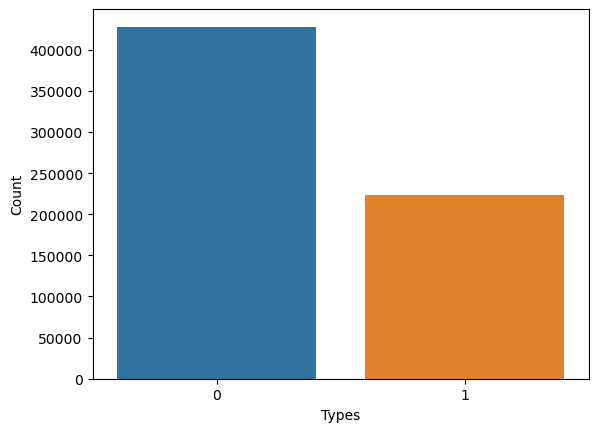

In [10]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

### Extracting url length

In [11]:
def get_url_length(url):
    prefixes = ['http://','https://','www.'] #Defining common prefixes for URLs and putting them in an array 
    
    for prefix in prefixes: #Loop to exclude prefix in length of URL
        if url.startswith(prefix):
            url = url[len(prefix):]
    
    #url = url.replace('www.','')#Removing www. from URL
    
    return len(url)#Returning length of URL

In [12]:
url_data['url_len'] = url_data['url'].apply(lambda x: get_url_length(str(x))) #Adding column to show URL length

In [13]:
url_data.head()

url  type  url_len
0                                   br-icloud.com.br     1       16
1                mp3raid.com/music/krizz_kaliko.html     0       35
2                    bopsecrets.org/rexroth/cr/1.htm     0       31
3  http://garage-pirenne.be/index.php?option=com_...     1       77
4  http://adventure-nicaragua.net/index.php?optio...     1      228

### Extracting top level domain

Extracting the top level domain from the url using the tld module

- 'as_object = true' instructs the function to return a parsed url object
- Cells ran with no error but domains are not found. This could be for multiple reasons. Most likely the domain does not exist on the internet anymore

def extract_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silenty = False, fix_protocol = True)
        pri_domain = res.parsed_url.netloc
    except:
        pri_domain = None
    return pri_domain

url_data['domain'] = url_data['url'].apply(lambda x: extract_tld(x))

url_data.head()

### Extracting character type and count

This involves a few functions that extract 3 different values of the url.

- Count of letters
- Count of digits
- Count of special characters
- Lastly, there will be a list of each of the special characters to identify which ones have been used and if they are suspicious

In [14]:
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = set(char.punctuation)
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

In [15]:
url_data['letters_count']        = url_data['url'].apply(lambda x: count_letters(x))
url_data['digits_count']         = url_data['url'].apply(lambda x: count_digits(x))
#url_data['special_chars_count']  = url_data['url'].apply(lambda x: count_special_chars(x))

In [16]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for i in feature:
    url_data[i] = url_data['url'].apply(lambda x: x.count(i))

In [17]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  #  %  +  $  !  *  ,  //  
0             13             0  0  0  1  0  2  0  0  0  0  0  0  0   0  
1             29             1  0  0  0  0  2  0  0  0  0  0  0  0   0  
2             25             1  0  0  0  0  2  0  0  0  0  0  0  0   0  
3             60             7  0  1  1  4  2  0  0  0  0  0  0  0   1  
4            199            22  0  1  1  3  2  0  0  0  0  0  0  0   1

### Identifying shortening services

If a shortening service has been used then the next functions will attempt to identify if the url has one attributed

In [18]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)

    if match:
        domain = match.group(1)
        common_shortening_services = ['bit', 'goo', 'tinyurl', 'ow', 't', 'is',
                                      'cli', 'yfrog', 'migre', 'ff', 'url4', 'twit',
                                      'su', 'snipurl', 'short', 'BudURL', 'ping', 
                                      'post', 'Just', 'bkite', 'snipr', 'fic', 
                                      'loopt', 'doiop', 'short', 'kl', 'wp', 
                                      'rubyurl', 'om', 'to', 'bit', 't', 'lnkd', 
                                      'db', 'qr', 'adf', 'goo', 'bitly', 'cur', 
                                      'tinyurl', 'ow', 'bit', 'ity', 'q', 'is', 
                                      'po', 'bc', 'twitthis', 'u', 'j', 'buzurl', 
                                      'cutt', 'u', 'yourls', 'x', 'prettylinkpro', 
                                      'scrnch', 'filoops', 'vzturl', 'qr', '1url', 
                                      'tweez', 'v', 'tr', 'link', 'zip']
        
        if domain.lower() in common_shortening_services:
            return 1
    return 0

In [19]:
url_data['shortened']  = url_data['url'].apply(lambda x: has_shortening_service(x))

In [20]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  #  %  +  $  !  *  ,  //  \
0             13             0  0  0  1  0  2  0  0  0  0  0  0  0   0   
1             29             1  0  0  0  0  2  0  0  0  0  0  0  0   0   
2             25             1  0  0  0  0  2  0  0  0  0  0  0  0   0   
3             60             7  0  1  1  4  2  0  0  0  0  0  0  0   1   
4            199            22  0  1  1  3  2  0  0  0  0  0  0  0   1   

   shortened  
0          0  
1          0  
2          0  
3          0  
4          0

### Checking if network location appears in the url more than once

In [21]:
def check_abnormal_url(url): #parsing url as perameter
    parsed_url = urlparse(url) #Creaing var to store the parsed url
    netloc = parsed_url.netloc #Creating 
    if netloc: #If statment with regex to check if netloc is contained in the url more than once
        netloc = str(netloc) #Converting netloc var to string
        match = re.search(netloc, url) #Creating a var for a match in the url
        if match:
            return 1
        else:
            return 0
    return 0

In [23]:
url_data['abnormal_url']  = url_data['url'].apply(lambda x: check_abnormal_url(x))

In [24]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  #  %  +  $  !  *  ,  //  \
0             13             0  0  0  1  0  2  0  0  0  0  0  0  0   0   
1             29             1  0  0  0  0  2  0  0  0  0  0  0  0   0   
2             25             1  0  0  0  0  2  0  0  0  0  0  0  0   0   
3             60             7  0  1  1  4  2  0  0  0  0  0  0  0   1   
4            199            22  0  1  1  3  2  0  0  0  0  0  0  0   1   

   shortened  abnormal_url  
0          0             0  
1          0             0  
2          0             0  
3          0             1  
4          0             1

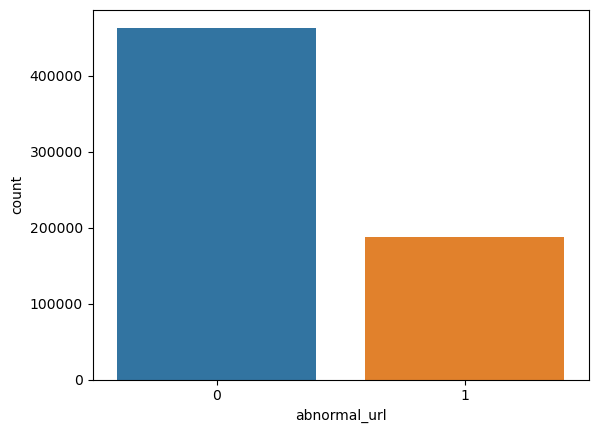

In [25]:
sns.countplot(x='abnormal_url', data=url_data);


### Checking if there is a secure http protocol in the url

In [26]:
def secure_http(url):
    return int(urlparse(url).scheme == 'https') 
#Using urlparse module again to detect if https is apparent

In [27]:
url_data['secure_http']  = url_data['url'].apply(lambda x: secure_http(x))

In [28]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  ...  %  +  $  !  *  ,  //  \
0             13             0  0  0  1  0  2  ...  0  0  0  0  0  0   0   
1             29             1  0  0  0  0  2  ...  0  0  0  0  0  0   0   
2             25             1  0  0  0  0  2  ...  0  0  0  0  0  0   0   
3             60             7  0  1  1  4  2  ...  0  0  0  0  0  0   1   
4            199            22  0  1  1  3  2  ...  0  0  0  0  0  0   1   

   shortened  abnormal_url  secure_http  
0          0             0            0  
1          0             0            0  
2          0             0            0  
3          0             1            0  
4          0             1            0  

[5 rows x 21 columns]

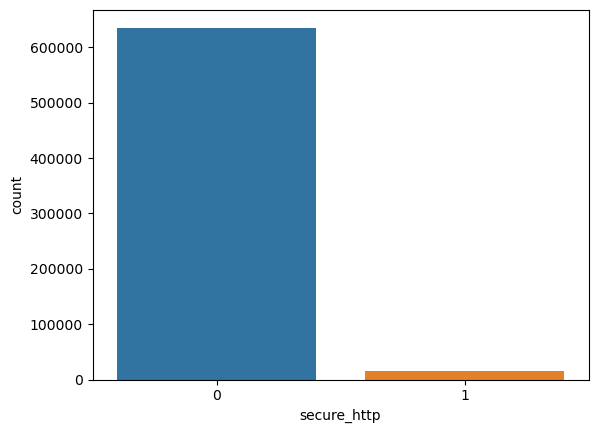

In [29]:
sns.countplot(x='secure_http', data=url_data);


In [30]:
sns.countplot(x='have_ip', data=url_data);


ValueError: Could not interpret input 'have_ip'

<AxesSubplot:>

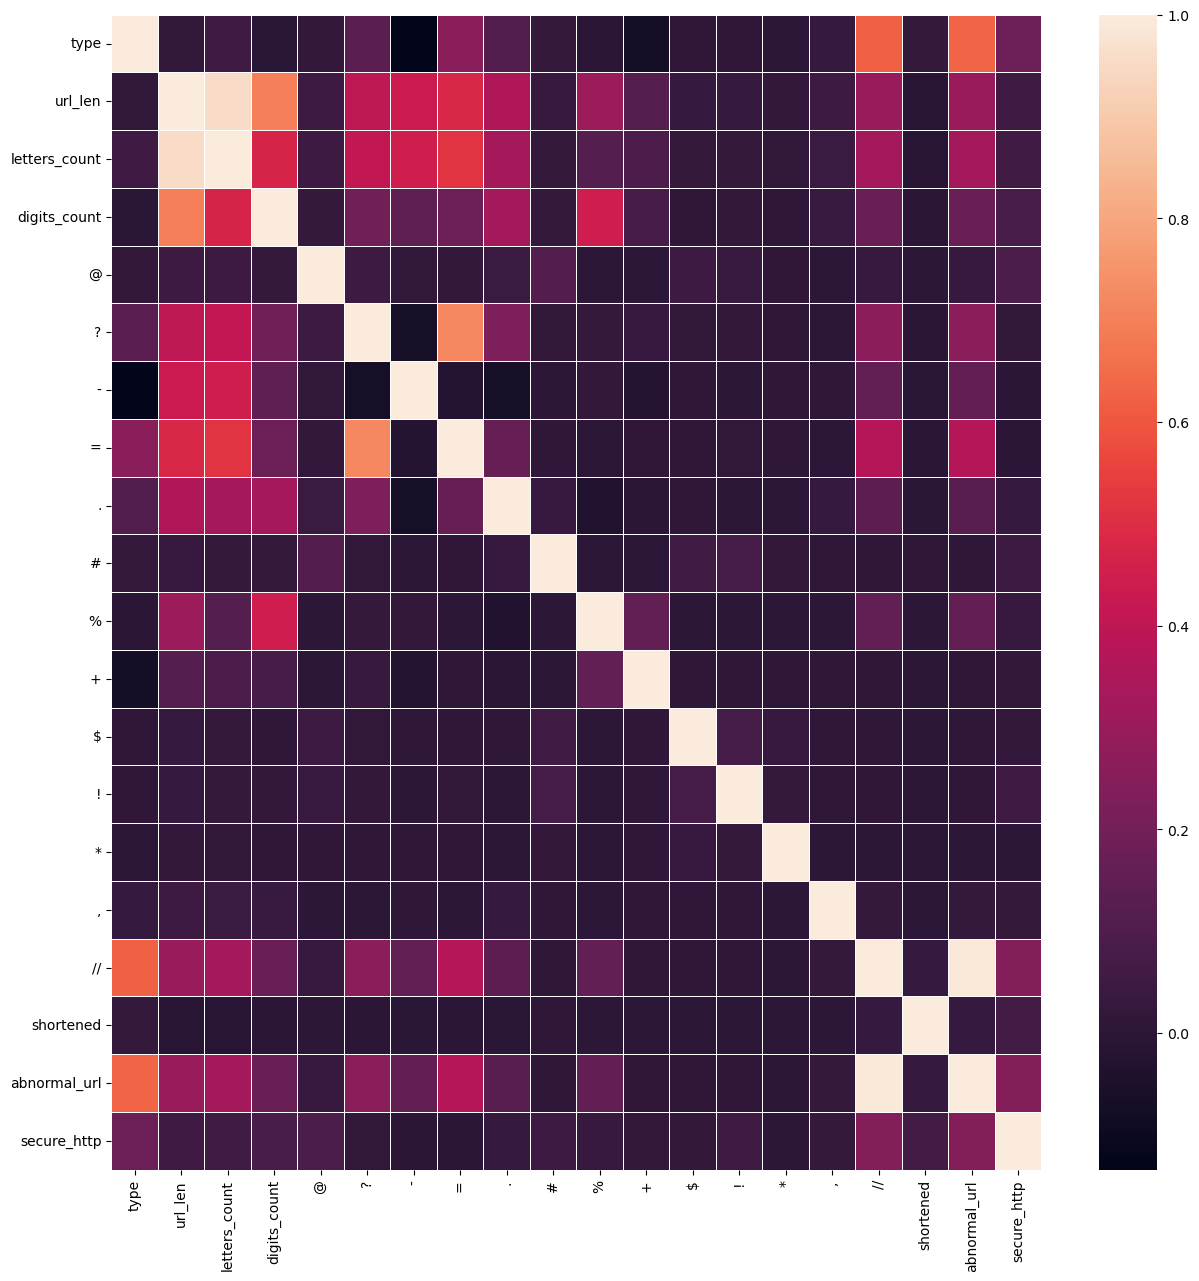

In [31]:

plt.figure(figsize=(15, 15))
sns.heatmap(url_data.corr(), linewidths=.5)

### Checking if url has IP address

In [32]:
def contain_ip(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass
    return 0

In [33]:
url_data['have_ip'] = url_data['url'].apply(lambda x: contain_ip(x))

In [34]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  ...  +  $  !  *  ,  //  \
0             13             0  0  0  1  0  2  ...  0  0  0  0  0   0   
1             29             1  0  0  0  0  2  ...  0  0  0  0  0   0   
2             25             1  0  0  0  0  2  ...  0  0  0  0  0   0   
3             60             7  0  1  1  4  2  ...  0  0  0  0  0   1   
4            199            22  0  1  1  3  2  ...  0  0  0  0  0   1   

   shortened  abnormal_url  secure_http  have_ip  
0          0             0            0        0  
1          0             0            0        0  
2          0             0            0        0  
3          0             1            0        0  
4          0             1            0        0  

[5 rows x 22 columns]

In [35]:
url_data.shape


(651191, 22)

In [36]:
url_data.isnull().sum()


url              0
type             0
url_len          0
letters_count    0
digits_count     0
@                0
?                0
-                0
=                0
.                0
#                0
%                0
+                0
$                0
!                0
*                0
,                0
//               0
shortened        0
abnormal_url     0
secure_http      0
have_ip          0
dtype: int64

In [37]:
X = url_data.drop(['url','type'],axis=1)#,'type_code'
y = url_data['type']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [39]:
url_data.head()

url  type  url_len  \
0                                   br-icloud.com.br     1       16   
1                mp3raid.com/music/krizz_kaliko.html     0       35   
2                    bopsecrets.org/rexroth/cr/1.htm     0       31   
3  http://garage-pirenne.be/index.php?option=com_...     1       77   
4  http://adventure-nicaragua.net/index.php?optio...     1      228   

   letters_count  digits_count  @  ?  -  =  .  ...  +  $  !  *  ,  //  \
0             13             0  0  0  1  0  2  ...  0  0  0  0  0   0   
1             29             1  0  0  0  0  2  ...  0  0  0  0  0   0   
2             25             1  0  0  0  0  2  ...  0  0  0  0  0   0   
3             60             7  0  1  1  4  2  ...  0  0  0  0  0   1   
4            199            22  0  1  1  3  2  ...  0  0  0  0  0   1   

   shortened  abnormal_url  secure_http  have_ip  
0          0             0            0        0  
1          0             0            0        0  
2          0             0            0        0  
3          0             1            0        0  
4          0             1            0        0  

[5 rows x 22 columns]

In [40]:
url_data.shape

(651191, 22)

In [41]:
df = pd.DataFrame(url_data)
df.to_csv('goPhish_featureExtracted.csv', index=False)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  92.52%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.94      0.83      0.88     44674

    accuracy                           0.93    130239
   macro avg       0.93      0.90      0.91    130239
weighted avg       0.93      0.93      0.92    130239

             Confusion_matrix 


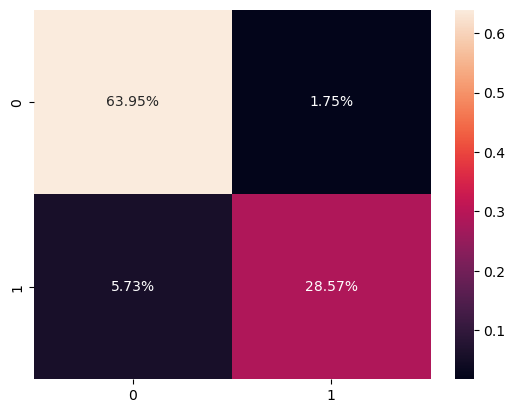

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  92.92%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.95      0.84      0.89     44674

    accuracy                           0.93    130239
   macro avg       0.94      0.91      0.92    130239
weighted avg       0.93      0.93      0.93    130239

             Confusion_matrix 


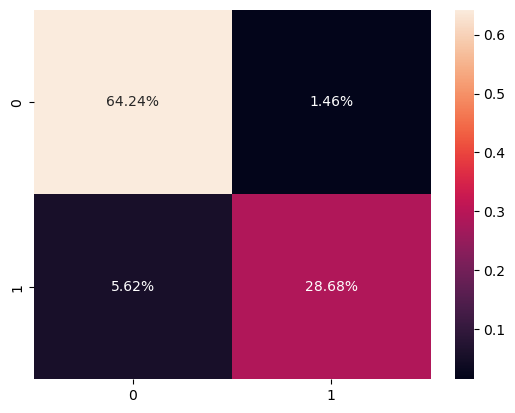

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  86.95%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     85565
           1       0.92      0.68      0.78     44674

    accuracy                           0.87    130239
   macro avg       0.88      0.82      0.84    130239
weighted avg       0.88      0.87      0.86    130239

             Confusion_matrix 


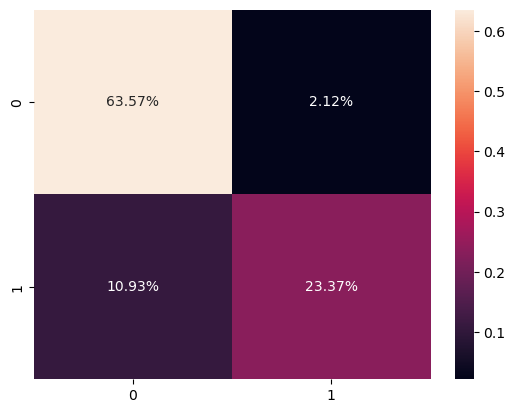

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 


D:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test Accuracy :  91.30%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     85565
           1       0.92      0.82      0.87     44674

    accuracy                           0.91    130239
   macro avg       0.91      0.89      0.90    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


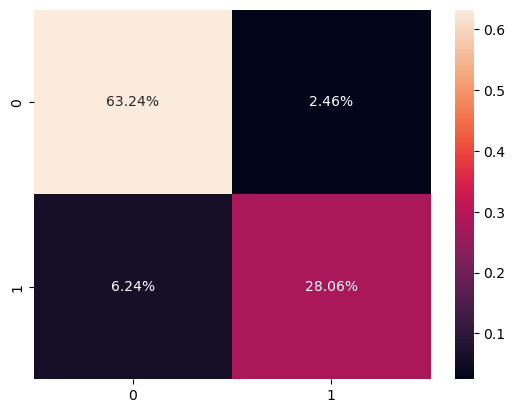

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  85.54%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     85565
           1       0.93      0.62      0.75     44674

    accuracy                           0.86    130239
   macro avg       0.88      0.80      0.82    130239
weighted avg       0.87      0.86      0.85    130239

             Confusion_matrix 


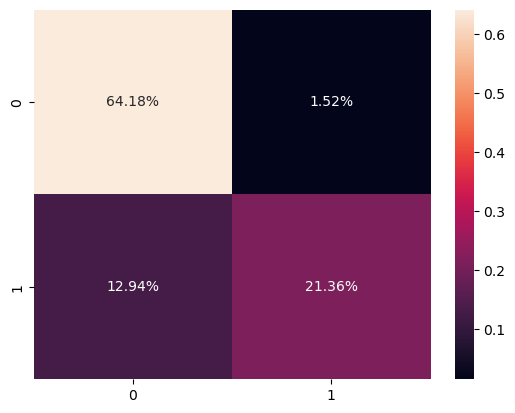

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  92.92%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.95      0.83      0.89     44674

    accuracy                           0.93    130239
   macro avg       0.94      0.91      0.92    130239
weighted avg       0.93      0.93      0.93    130239

             Confusion_matrix 


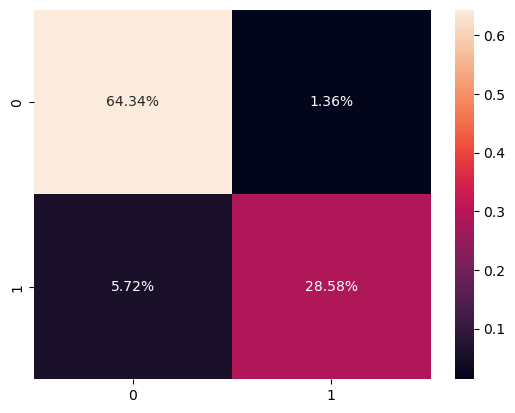

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  75.86%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.74      0.99      0.84     85565
           1       0.92      0.32      0.48     44674

    accuracy                           0.76    130239
   macro avg       0.83      0.65      0.66    130239
weighted avg       0.80      0.76      0.72    130239

             Confusion_matrix 


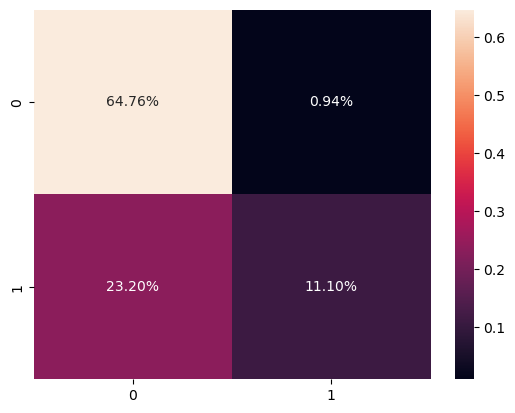

###################- End -###################


In [42]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')